In [1]:
import os
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import torch

from sklearn.metrics import accuracy_score

from src import data

In [2]:
DATA_DIR = os.path.join(os.getcwd(), 'data/')
BATCH_SIZE = 64

train_path = os.path.join(DATA_DIR, 'train.tsv')
validation_path = os.path.join(DATA_DIR, 'validation.tsv')
test_path = os.path.join(DATA_DIR, 'test.tsv')

logits_path = os.path.join(DATA_DIR, 'logits.tsv')

In [3]:
train = pd.read_csv(train_path, sep='\t', header=None)
logits = pd.read_csv(logits_path, sep='\t', header=None)

In [4]:
train.head()

,0,1,2
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
f'Teacher accuracy: {accuracy_score(train[2], np.array(logits).argmax(axis=1)):.3f}'

'Teacher accuracy: 0.933'

In [6]:
train_a, train_b, train_targets = data.get_data(train_path)
validation_a, validation_b, validation_targets = data.get_data(validation_path)
test_a, test_b, test_targets = data.get_data(test_path)

train_logits = data.get_logits(logits_path)

In [7]:
vocab = dict()

for dataset in (train_a, train_b, validation_a, validation_b, test_a, test_b):
    for text in dataset:
        for word in text:
            vocab[word] = vocab.get(word, 0) + 1
            
exist_words = set(vocab.keys())

In [8]:
word2index, embeddings = data.get_word2vec(exist_words=exist_words)

Read word2vec:  74%|███████▎  | 57958/78643 [00:37<00:13, 1536.74it/s] 


In [9]:
dropped_n = 0

for word in exist_words.difference(set(word2index.keys())):
    dropped_n += vocab[word]
    
f'Dropped {dropped_n * 100 / sum(vocab.values()):.3f} % of data'

'Dropped 0.471 % of data'

In [10]:
prediction = torch.softmax(torch.tensor(train_logits), -1).max(-1)[0]

/Users/b.zubarev/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


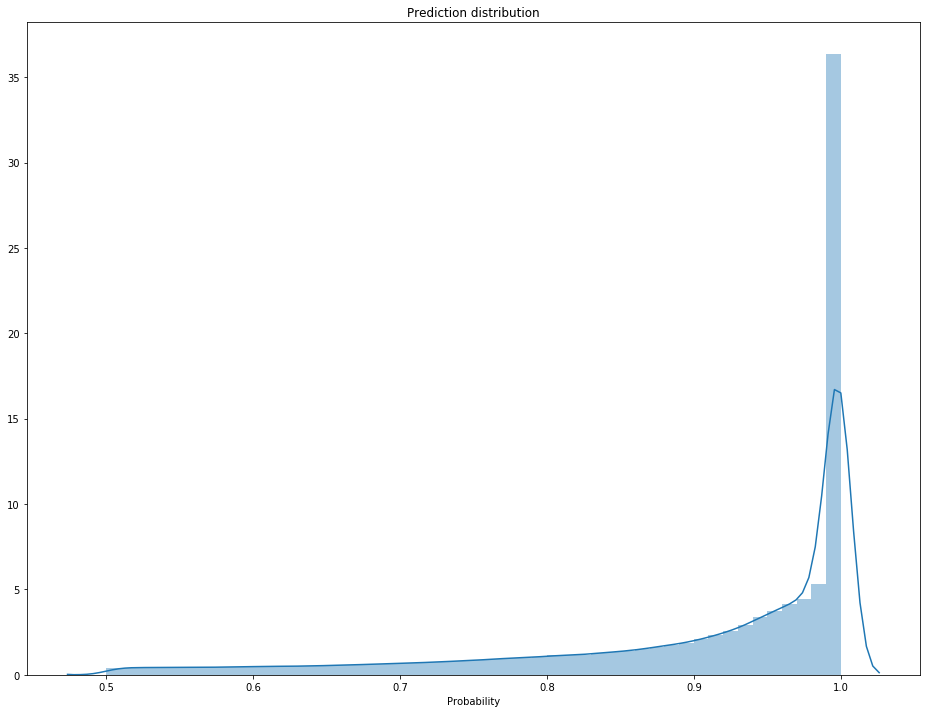

In [11]:
plt.figure(figsize=(16, 12))
plt.title('Prediction distribution')
plt.xlabel('Probability')
sns.distplot(prediction)

In [12]:
threshold = 0.9
value = ((prediction > threshold).sum().float() * 100 / prediction.size(0)).item()
f'Probability with {int(threshold*100)}+: {value:.2f} %'

'Probability with 90+: 67.22 %'

In [13]:
with open(os.path.join(DATA_DIR, 'word2index.json'), 'w') as f:
    json.dump(word2index, f)

In [14]:
np.save(os.path.join(DATA_DIR, 'embeddings.npy'), embeddings)

In [15]:
train_dataset = data.PairedData(word2index, train_a, train_b, train_targets, logits=train_logits)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

validation_dataset = data.PairedData(word2index, validation_a, validation_b, validation_targets)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = data.PairedData(word2index, test_a, test_b, test_targets)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
lengths = list()

for texts_a, texts_b, targets, teacher_logits in train_loader:
    lengths.extend((texts_a != 0).sum(-1).tolist())

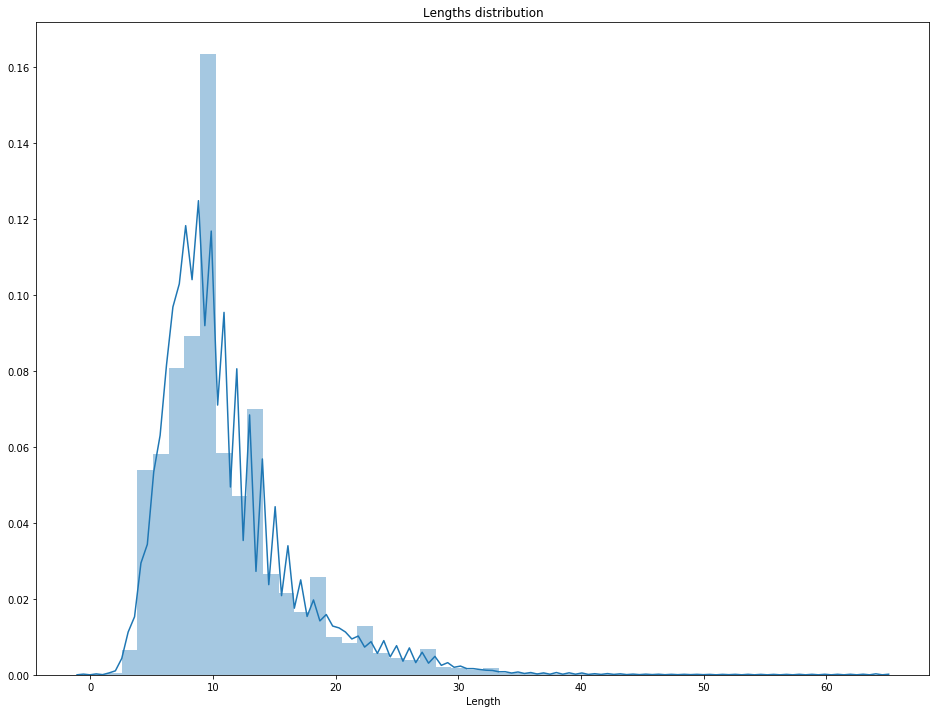

In [17]:
plt.figure(figsize=(16, 12))
plt.title('Lengths distribution')
plt.xlabel('Length')
sns.distplot(lengths)